<a href="https://colab.research.google.com/github/drovosekovanton/Skillfactory_game/blob/master/Skillfactory_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание работы

Задание: исследовать факторы, влияющие на уровень потребления электрической энергии жителями Великобритании.

Для работы выбраны отдельные группы данных из предоставленного датасета, они описаны ниже в разделе "Описание файлов датасета".

Сам исходный датасет доступен на [Kaggle](https://www.kaggle.com/jeanmidev/smart-meters-in-london).
Модифицированный датасет (с уже обработанными даными) доступен по [этой ссылке (Google Drive)](https://drive.google.com/drive/folders/1oVN31sW5rC_RDhA4w3azI0LwELBO3mx5?usp=sharing).

#Подготовка

### Импорт используемых библиотек

In [0]:
import pandas as pd             # pandas itself
import numpy as np              # numpy for numpy aggregation functions
from pathlib import PurePath    # working with cross-platform paths
from google.colab import drive  # some kind of local meme
import os                       # listing files in mounted directory
from datetime import datetime   # datetime functions and structures
from datetime import timedelta
import progressbar              # for napping at long-time operations
import matplotlib.pyplot as plt # show ugly graphs
import seaborn as sns           # show beautiful graphs
import warnings                 # nothing to see here,
warnings.simplefilter('ignore') # move along, citizen


# mount root of your google drive to '/content/drive'
drive.mount('/content/drive')
# supposing that dataset is inside 
# 'Colab Notebooks/Skillfactory_game_data' folder
file_prefix = PurePath('/content/drive/My Drive/'
                        'Colab Notebooks/Skillfactory_game_data')

# some plot stuff
%matplotlib inline
sns.set()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Описание файлов датасета

**informations_households.csv**

Информация о датчиках энергопотребления и краткие сведения о домах, в которых эти датчики установлены. Столбцы датафрейма:

|Колонка|Описание|
|:-|:-|
|LCLid|id датчика|
|stdorToU|форма оплаты за электроэнергию в доме, <wbr>в котором установлен датчик <wbr>(Std – стандартная, <wbr>ToU – Time of Use, оплата зависит от времени суток)|
|Acorn, <wbr>Acorn_grouped|информация о том, <wbr>к какой категории потребителей по системе ACORN <wbr>относится семья, проживающая в данном доме|
|file|имя файла, содержащего показатели счётчиков|


**halfhourly_dataset\block_{0 - 111}.csv**

Архив содержит 112 файлов, содержащих данные об энергопотреблении, получаемые с каждого счётчика 1 раз в 30 минут. Каждый файл содержит информацию с датчиков, установленных в одном доме. Столбцы датафрейма:

|Колонка|Описание|
|:-|:-|
|LCLid|id датчика|
|tstp|дата и время фиксации показателей|
|energy(kWh/hh)|потреблённая электроэнергия|

**hourly_dataset\block_{0 - 111}.csv**

Архив содержит 112 файлов, содержащих данные об энергопотреблении, получаемые с каждого счётчика 1 раз в час. Каждый файл содержит информацию с датчиков, установленных в одном доме. Столбцы датафрейма:

|Колонка|Описание|
|:-|:-|
|LCLid|id датчика|
|tstp|дата и время фиксации показателей|
|energy|потреблённая электроэнергия|

**daily_dataset\daily_dataset\block_{0 - 111}.csv**

Архив содержит 112 файлов, содержащих обобщённые данные об энергопотреблении за каждые сутки. Каждый файл содержит информацию с датчиков, установленных в одном доме. Столбцы датафрейма:

|Колонка|Описание|
|:-|:-|
|LCLid|id датчика|
|day|дата|
|energy_median|медиана суточных показателей|
|energy_mean|среднее арифметическое <wbr>суточных показателей|
|energy_max|максимальное значение энергопотребления, <wbr>зафиксированное датчиком в течение дня|
|energy_count|количество показателей, <wbr>зафиксированных датчиком в течение дня|
|energy_std|стандартное отклонение|
|energy_sum|сумма значений всех показателей|
|energy_min|минимальное значение энергопотребления, <wbr>зафиксированное датчиком в течение дня|


**acorn_details.csv**

Данные о группах потребителей согласно классификации ACORN. При характеристике групп в данном датафрейме используется сравнение каждой группы с общенациональными показателями. Так, если значение ячейки по какому-либо показателю составляет 150 это означает, что в рассматриваемой группе этот показатель встречается в 1,5 раза чаще, чем в целом по стране. Столбцы датафрейма:

|Колонка|Описание|
|:-|:-|
|MAIN CATEGORIES, <wbr>CATEGORIES, <wbr>REFERENCE|показатели, по которым осуществляется сравнение групп|
|ACORN-A, <wbr>ACORN-B, <wbr>ACORN-C, <wbr>ACORN-D, <wbr>ACORN-E, <wbr>ACORN-F, <wbr>ACORN-G, <wbr>ACORN-H, <wbr>ACORN-I, <wbr>ACORN-J, <wbr>ACORN-K, <wbr>ACORN-L, <wbr>ACORN-M, <wbr>ACORN-N, <wbr>ACORN-O, <wbr>ACORN-P, <wbr>ACORN-Q|частота встречаемости каждого из рассмотренных признаков в каждой группе|

**weather_daily_darksky.csv**

Обобщённые данные о погоде за день. Столбцов в таблице много, их названия говорят сами за себя. Будем использовать следующие столбцы:

|Колонка|Описание|
|:-|:-|
|temperatureMax|максимальное значение температуры воздуха|
|windBearing|направление ветра (по азимуту)|
|icon|стандартизованное словесное описание погодных условий|
|windSpeed|скорость ветра|
|visibility|видимость (в милях)|
|time|время начала сбора данных|
|temperatureMin|минимальная температура за сутки|
|sunriseTime|время восхода|


**weather_hourly_darksky.csv**

Почасовые сведения о погоде. Столбцы датафрейма:

|Колонка|Описание|
|:-|:-|
|visibility|видимость в милях|
|windBearing|направление ветра (по азимуту)|
|temperature|температура воздуха|
|time|время записи показателей|
|dewPoint|точка росы|
|pressure|атмосферное давление|
|apparentTemperature|температура комфорта|
|windSpeed|скорость ветра|
|precipType|тип осадков|
|icon|стандартизованное словесное описание погодных условий|
|humidity|относительная влажность|
|summary|нестандартизованное словесное описание погодных условий|


**uk_bank_holidays.csv**

Официальные праздничные выходные дни Великобритании
Файл слегка отличается от исходного (названия приведены к читаемому виду, убраны пояснения к перенесённым дням).

|Колонка|Описание|
|:-|:-|
|Bank holidays|Дата|
|Type|Название праздника|



### Загрузка сводных данных

In [0]:
# we'll make some speedups knowing data's structures
informations_households = pd.read_csv(
    file_prefix / 'informations_households.csv',
    )
daily_dataset = pd.read_csv(
    file_prefix / 'daily_dataset' / 'daily_dataset.csv.zip',
    parse_dates=['day'],
    infer_datetime_format=True,
    na_values='Null',
    dtype={'energy_median': np.double,
           'energy_mean': np.double,
           'energy_max': np.double,
           'energy_count': np.int8,
           'energy_std': np.double,
           'energy_sum': np.double,
           'energy_min': np.double
           }
    )
acorn_details = pd.read_csv(
    file_prefix / 'acorn_details.csv',
    encoding='cp1251'
    )
weather_daily_darksky = pd.read_csv(
    file_prefix / 'weather_daily_darksky.csv',
    parse_dates=['temperatureMaxTime',
                 'temperatureMinTime',
                 'apparentTemperatureMinTime',
                 'apparentTemperatureHighTime',
                 'time', # <- purified date of this row
                 'sunsetTime',
                 'sunriseTime',
                 'uvIndexTime',
                 'temperatureHighTime',
                 'temperatureLowTime',
                 'apparentTemperatureMaxTime',
                 'apparentTemperatureLowTime'],
        infer_datetime_format=True
    )
weather_hourly_darksky = pd.read_csv(
    file_prefix / 'weather_hourly_darksky.csv',
    parse_dates=['time'], # <- purified date and time of this row
    infer_datetime_format=True
    )
uk_holidays = pd.read_csv(
    file_prefix / 'uk_bank_holidays.csv',
    parse_dates=['Bank holidays']
    )

## Общие функции работы с данными

### Функция для получения данных по ACORN

Отдаёт самые частовстречающиеся категории выбранной группы ACORN

In [0]:
def get_acorn_info(acorn_group, ref):
    return acorn_details[acorn_details['CATEGORIES'] == ref]\
    .nlargest(1, columns=acorn_group)['REFERENCE'].iloc[0]

get_acorn_info('ACORN-A', 'Age')

'Aged 65-74'

### Функция для получения информации по часовому потреблению по списку LCLid

работает с данными /hourly_dataset/block*.csv.zip, созданными при предварительной подготовке данных

In [0]:
def get_energy_by_LCLid(LCLids):

    # transform any type to list
    try:
        LCLids = list(LCLids)
    except TypeError:
        print(f'LCLids has incompatible type: {type(LCList)}')

    files_to_proceed = informations_households[
            informations_households['LCLid'].isin(LCLids)]['file']
    result_df = pd.DataFrame(columns=['LCLid', 'tstp', 'energy'])
    bar = progressbar.ProgressBar(prefix='retrieving files: ')
    for file in bar(files_to_proceed):
        z = pd.read_csv(file_prefix / 'hourly_dataset' / f'{file}.csv.zip',
                        parse_dates=['tstp'],
                        infer_datetime_format=True,
                        na_values='Null',
                        dtype={'energy': np.double})
        z = z[z['LCLid'].isin(LCLids)]
        z = z\
        .groupby(by=['LCLid','tstp'])\
        .sum()\
        .reset_index()
        result_df = pd.concat([result_df, z], copy=False)
    return result_df

get_energy_by_LCLid(['MAC000002']).info()

retrieving files: 100% (1 of 1) |########| Elapsed Time: 0:00:00 Time:  0:00:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12074 entries, 0 to 12073
Data columns (total 3 columns):
LCLid     12074 non-null object
tstp      12074 non-null datetime64[ns]
energy    12074 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 377.3+ KB


## Предварительная обработка данных

### ✔ Предварительная обработка получасовых значений и сведение их к часовым

<font color='red'>**Уже выполнено, больше не запускать**</font>

Сильно уменьшится сложность обработки при изъятии данных по LCLid.
Можно будет при загрузке сразу определять тип данных у даты и у показаний счётчика, не будет пустых зачений - то есть предварительно проводится очистка и обработка данных, остаётся только загрузка через read_csv и работа с ними без промежуточных этапов.



```
Результат:
файлы hourly_dataset/block_xxx.csv.zip
формат файла аналогичен halfhourly_dataset/block_xxx.csv.zip, только отсчёты один раз в час

Использует в работе:
halfhourly_dataset/block_xxx.csv.zip
```



In [0]:
# # creating progressbar, coz there is much to work
# bar = progressbar.ProgressBar(prefix='Processing files: ')
# for file in bar(
#     os.listdir(file_prefix / 'halfhourly_dataset')
#     ):
#     # !ls 'drive/My Drive/Colab Notebooks/Skillfactory_game_data'
#     # define new file name
#     filename = file_prefix / 'hourly_dataset' / file.split('/')[-1]
#     z = pd.read_csv(
#         file,
#         parse_dates=['tstp'],
#         infer_datetime_format=True,
#         na_values='Null',
#         keep_default_na=True,
#     )
#     z.columns = ['LCLid', 'tstp', 'energy']
#     z.fillna(0, inplace=True)
#     # np.float16 is too rough even for thousandths
#     z['energy'] = z['energy'].astype(np.double, copy=False)
#     # now we need to concatenate two halves of an hour
#     # roughing them to hours.
#     # this place is extremely slow,
#     # we need to get rid of this conversion
#     z['tstp'] = z['tstp'].apply(
#         lambda x: pd.Timestamp(x)\
#         .replace(minute=0, second=0)\
#         .to_datetime64())
#     # grouping, summing and regrouping back one level,
#     # converting LCLid column to index.
#     z = z \
#     .groupby(by=['LCLid', 'tstp'])\
#     .agg(np.sum)\
#     .reset_index(['tstp'])
#     # round energy consumption value to 3 digits, that should be enough
#     z.to_csv(filename, float_format='%.3f')

### Добавление рабочих и выходных дней в список праздничных дней

<font color='red'>**можно запускать каждый раз, берёт мало времени на выполнение**</font>

In [0]:
uk_holidays.rename(
    columns={'Bank holidays': 'day'},
    inplace=True)
# adding work days and weekdays to uk_holidays
for current_date in pd.date_range(
                daily_dataset.day.min(),
                daily_dataset.day.max(),
                freq='D'):

    uk_holidays = uk_holidays.append(
        {'day': current_date,
         'Type': 'Weekend' if current_date.weekday() in [5, 6] else 'Work Day'
        }, ignore_index=True)
    # drop duplicates of original holidays
    uk_holidays.drop_duplicates('day', keep='first', inplace=True)

# uk_holidays.to_csv(file_prefix / 'uk_holidays.csv', index=False)
# uk_holidays = pd.read_csv(
#     file_prefix / 'uk_holidays.csv',
#     parse_dates=['day']
# )

### Сведение получасовых данных к часовым, сохранение их в один файл. Без LCLids

Данные сведены из разных файлов в hourly_energy_use.csv

<font color='red'>**Уже выполнено, запускать только для загрузки обработанных данных**</font>

In [0]:
# hourly_energy_use = pd.DataFrame(columns=['tstp', 'energy'])
# files = os.listdir(file_prefix / 'halfhourly_dataset')
# bar = progressbar.ProgressBar(
#     prefix='retrieving files: ')

# for file_name in bar(files):
#     temp = pd.read_csv(
#         file_prefix / 'hourly_dataset' / file_name,
#         parse_dates=['tstp'],
#         na_values='Null')
    
#     temp['energy'] = temp['energy'].fillna('0').astype(np.double)
#     # now we need to concatenate two halves of an hour
#     # roughing them to hours.
#     temp['tstp'] = pd.to_datetime(
#         temp['tstp'].dt.strftime('%Y-%m-%d %H'))
#     # grouping, summing, ungrouping, appending
#     hourly_energy_use = hourly_energy_use.append(
#         temp.groupby(['tstp'])['energy'].sum().reset_index(),
#         ignore_index=False
#     )

# hourly_energy_use = hourly_energy_use\
#     .groupby(['tstp'])['energy']\
#     .sum()\
#     .reset_index()

# hourly_energy_use.to_csv(
#     file_prefix / 'hourly_energy_use.csv',
#     index=False)

hourly_energy_use = pd.read_csv(
    file_prefix / 'hourly_energy_use.csv',
    parse_dates=['tstp'])


# Задачи на аналитику

## Очистка данных

Проверка имеющихся групп ACORN

In [0]:
display(informations_households['Acorn'].unique())

array(['ACORN-', 'ACORN-A', 'ACORN-B', 'ACORN-C', 'ACORN-D', 'ACORN-E',
       'ACORN-F', 'ACORN-G', 'ACORN-H', 'ACORN-I', 'ACORN-J', 'ACORN-K',
       'ACORN-L', 'ACORN-M', 'ACORN-N', 'ACORN-O', 'ACORN-P', 'ACORN-Q',
       'ACORN-U'], dtype=object)

Присутствует 'ACORN-U(nclassified)' который не принадлежит ни одной ACORN-метрике, и 'ACORN-', который скорее всего является неизвестным типом домохозяйства. В любом случае, их нет в acorn_details.csv, поэтому уберём подобные домохозяйства

In [0]:
informations_households = informations_households[
    ~informations_households['Acorn'].isin(['ACORN-U', 'ACORN-'])
]

Рассмотрим данные потребления электроэнергии по дням:

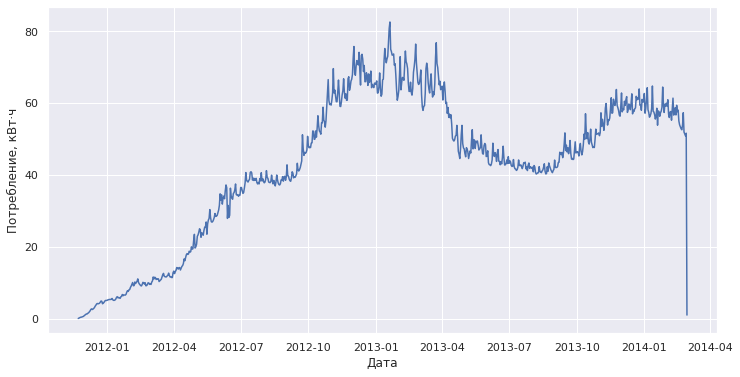

In [0]:
t1 = daily_dataset.groupby('day')['energy_sum'].sum().reset_index()
t1['energy_sum'] /= 1_000
plt.figure(figsize=(12, 6))
axe = sns.lineplot(x='day', y='energy_sum', data=t1)
axe.set(xlabel='Дата', ylabel='Потребление, кВт·ч');

Видно, что в самом начале сбора показаний данные о потреблении малы и впоследствии растут; эти малые показания будут давать погрешности в анализе, и по этой причине оставим только те значения, что имеют суммарное значение энергопотребления более 80% от средних показателей за весь период.
Также уберём последний месяц сбора информации, там происходило снятие счётчиков, и это время также явно выделяется из общей группы

In [0]:
z = t1['energy_sum'].mean() * 0.8
t1[t1['energy_sum'] >= z].sort_values(by='energy_sum').head()

,day,energy_sum
220,2012-06-30,34.421895
216,2012-06-26,34.439920
219,2012-06-29,34.444352
195,2012-06-05,34.515655
215,2012-06-25,34.570670


Будем начинать анализ с июля 2012 года

In [0]:
start_period_rep = datetime.strptime('2012-07-01', '%Y-%m-%d')
end_period_rep = daily_dataset['day'].max() - timedelta(days=30)
daily_dataset = daily_dataset[
    (daily_dataset['day'] >= start_period_rep) &\
    (daily_dataset['day'] <= end_period_rep)]

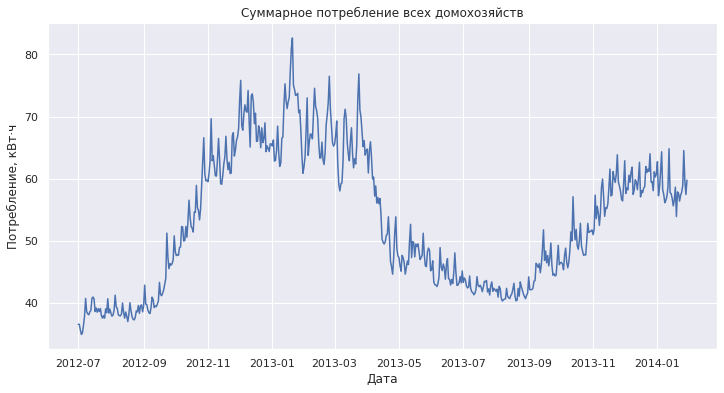

In [0]:
t1 = daily_dataset.groupby('day')['energy_sum'].sum().reset_index()
t1['energy_sum'] /= 1_000
plt.figure(figsize=(12, 6))
plt.title('Суммарное потребление всех домохозяйств')
axe = sns.lineplot(x='day', y='energy_sum', data=t1)
axe.set(xlabel='Дата', ylabel='Потребление, кВт·ч');

## Подготовим дополнительные таблицы

Соберем данные по суммарным потреблениям в домохозяйствах за весь период наблюдений

In [0]:
energy_use_hh = informations_households.merge(
    daily_dataset\
    .groupby(['LCLid'])['energy_sum']\
    .sum()\
    .sort_values(),
     on='LCLid')
energy_use_hh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5515 entries, 0 to 5514
Data columns (total 6 columns):
LCLid            5515 non-null object
stdorToU         5515 non-null object
Acorn            5515 non-null object
Acorn_grouped    5515 non-null object
file             5515 non-null object
energy_sum       5515 non-null float64
dtypes: float64(1), object(5)
memory usage: 301.6+ KB


Соберем данные по суммарному потреблению за весь наблюдаемый период с периодом в день и с информацией о типе дня недели и погоде

In [0]:
# there is a bug, half of the days have wrong time in 'time' column
# like 2013-07-31 23:00:00 instead of 2013-08-01 00:00:00
# therefore merge doesn't work properly
# so we make new 'day' column with proper value
weather_daily_darksky['day'] = \
    weather_daily_darksky['sunriseTime'].dt.normalize()

energy_use_d = daily_dataset\
    .groupby('day')['energy_sum']\
    .sum()\
    .reset_index()\
    .merge(uk_holidays, 
            on='day',
            how='left')\
    .merge(
        weather_daily_darksky[[
            'day',
            'temperatureMax',
            'temperatureMin',
            'windBearing',
            'windSpeed',
            'icon',
            'visibility']],
           on='day',
           how='left')
# add day of week column
energy_use_d['dow'] = energy_use_d['day'].dt.dayofweek

energy_use_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 578 entries, 0 to 577
Data columns (total 10 columns):
day               578 non-null datetime64[ns]
energy_sum        578 non-null float64
Type              578 non-null object
temperatureMax    578 non-null float64
temperatureMin    578 non-null float64
windBearing       578 non-null int64
windSpeed         578 non-null float64
icon              578 non-null object
visibility        578 non-null float64
dow               578 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 49.7+ KB


Соберем данные за весь наблюдаемый период с периодом в час с информацией о погоде

In [0]:
energy_use_h = weather_hourly_darksky[[
                            'time',
                            'temperature',
                            'windBearing',
                            'windSpeed',
                            'icon',
                            'visibility']]\
                .merge(hourly_energy_use,
                       left_on='time',
                       right_on='tstp')\
                .sort_values(by='energy', 
                            ascending=False)
energy_use_h['hour'] = energy_use_h['time'].dt.hour

energy_use_h.info( )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19862 entries, 14218 to 528
Data columns (total 9 columns):
time           19862 non-null datetime64[ns]
temperature    19862 non-null float64
windBearing    19862 non-null int64
windSpeed      19862 non-null float64
icon           19862 non-null object
visibility     19862 non-null float64
tstp           19862 non-null datetime64[ns]
energy         19862 non-null float64
hour           19862 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 1.5+ MB


Соберем dataframe с описанием групп ACORN.

Это выжимка из исходной таблицы acorn_detail, показывающая наиболее интересные параметры.

In [0]:
acorn_df = acorn_details.columns[3:].to_frame(name='ACORN', index=False)
acorn_categs = ['Age',
                'Geography',
                'House Type',
                'House Size',
                'House Value',
                'Structure',
                'Children in household',
                'Household Size','Economic Activity',
                'Social Grade',
                'Occupation',
                'Behaviours & Lifestyle',
                'Financial Situation',
                'Credit Cards',
                'Interests & Hobbies',
                'Holiday Destination/Type']
for category in acorn_categs:
    acorn_df[category] = acorn_df['ACORN'].apply(get_acorn_info, 
                                                 args=(category,))

## Базовый анализ по домохозяйствам

### Информация о распределении потребления электроэнергии в зависимости от группы ACORN

Рассмотрим общее количество, суммарное потребление энергии и среднее значение потребления энергии домохозяйств в разбивке на группы ACORN, категории комфорта и категории учета электроэнергии. Возьмём десять наиболее потребляющих (в среднем) групп ACORN

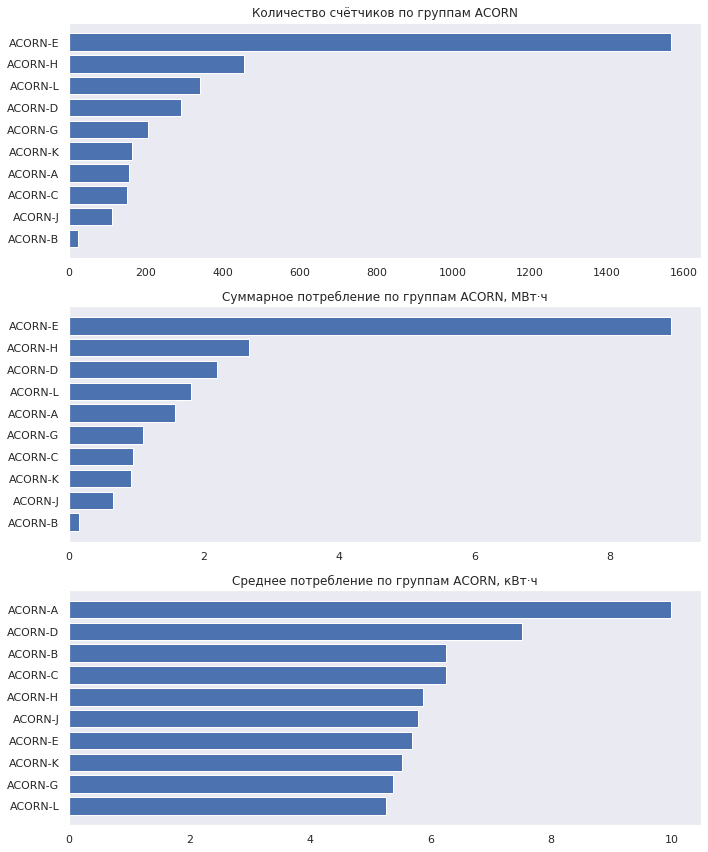

In [0]:
t1 = energy_use_hh.groupby('Acorn')['energy_sum']\
                  .agg({'count_group': 'count',
                        'sum_group': 'sum',
                        'mean_group': 'mean'})\
                  .nlargest(10, columns='mean_group')\
                  .reset_index()
fig, axes = plt.subplots(3, 1, figsize=(10, 12), tight_layout=True)
axes[0].grid(b=None)
axes[0].barh(y=t1.sort_values(by='count_group')['Acorn'],
             width=t1.sort_values(by='count_group')['count_group'])
axes[0].set_title('Количество счётчиков по группам ACORN')
axes[1].grid(b=None)
axes[1].barh(y=t1.sort_values(by='sum_group')['Acorn'],
             width=t1.sort_values(by='sum_group')['sum_group'] / 1_000_000)
axes[1].set_title('Суммарное потребление по группам ACORN, МВт·ч')
axes[2].grid(b=None)
axes[2].barh(y=t1.sort_values(by='mean_group')['Acorn'],
             width=t1.sort_values(by='mean_group')['mean_group'] / 1_000)
axes[2].set_title('Среднее потребление по группам ACORN, кВт·ч');

Выводы по графикам:

* Поскольку количество домохозяйств, принадлежащих к группе ACORN-E максимальное, то и суммарное потребление по ним максимальное
* Но среднее значение говорит нам, что домохозяйства группы ACORN-A потребляют больше электроэнергии

Ниже есть описание различных параметров интересующих групп:

In [0]:
acorn_df[acorn_df['ACORN'].isin(['ACORN-A','ACORN-E'])].set_index('ACORN').T

ACORN,ACORN-A,ACORN-E
Age,Aged 65-74,Age 25-34
Geography,England,England
House Type,Detached house,Flat or maisonette
House Size,Number of Beds : 5 plus,Number of Beds : 1
House Value,House Value 1m+,House Value 500k-750k
Structure,Couple family with dependent children,All student households
Children in household,Children at home : 0,Children at home : 1
Household Size,Household size : 5+ persons,Household size : 3-4 persons
Economic Activity,Self-employed,Employee Full-Time
Social Grade,A,B


Из описания групп становится понятно, что по среднему показателю потребления представитель такого домохозяства скорее всего уже пожилой человек 65+, имеющий большой, дорогой дом и живущий с детьми. В основном же представителями домохозяйств являются более молодые люди 25-34 лет, имеющие 1 ребенка.

### Информация о распределении потребления энергии в зависимости от типа установленного счетчика

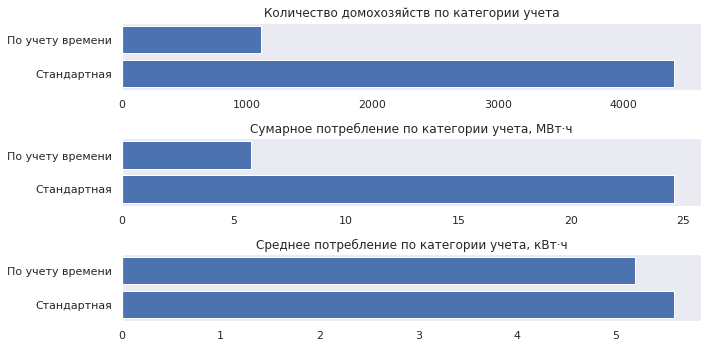

In [0]:
 t1 = energy_use_hh.groupby('stdorToU')['energy_sum']\
                  .agg({'count_group': 'count',
                        'sum_group': 'sum',
                        'mean_group': 'mean'})\
                  .reset_index()
fig, axes = plt.subplots(3, 1, figsize=(10, 5), tight_layout=True)
axes[0].grid(b=None)
axes[0].barh(y=['Стандартная', 'По учету времени'],
             width=t1['count_group'])
axes[0].set_title('Количество домохозяйств по категории учета')
axes[1].grid(b=None)
axes[1].barh(y=['Стандартная', 'По учету времени'],
             width=t1['sum_group'] / 1_000_000)
axes[1].set_title('Сумарное потребление по категории учета, МВт·ч')
axes[2].grid(b=None)
axes[2].barh(y=['Стандартная', 'По учету времени'],
             width=t1['mean_group'] / 1_000)
axes[2].set_title('Среднее потребление по категории учета, кВт·ч');

Выводы по графикам:

Хотелось бы сделать вывод, что потребление энергии домохозяйством практически никак не зависит от типа установленного счетчика, но становится понятно, что текущей детализации недостаточно (пользователи с повременным учетом могут потреблять больше в дневное время, а суммарно за день показания будут примерно равны), необходимо сравнение по часам. Суммарные данные дают понять, что самих домохозяйств со стандартным учетом больше

### Информация о распределении потребления энергии в зависимости от категории комфорта

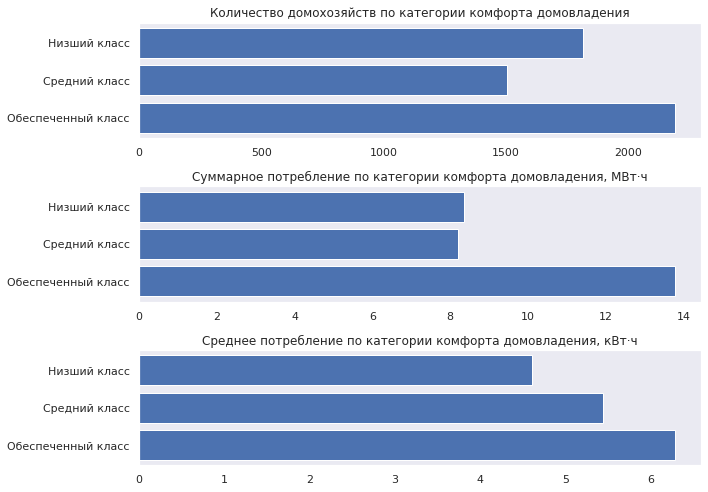

In [0]:
t1 = energy_use_hh.groupby('Acorn_grouped')['energy_sum']\
                  .agg({'count_group': 'count',
                        'sum_group': 'sum',
                        'mean_group': 'mean'})\
                  .rename({'Adversity': 'Низший класс',
                           'Comfortable': 'Средний класс',
                           'Affluent': 'Обеспеченный класс'})\
                  .sort_values(by='mean_group', 
                               ascending=False)\
                  .reset_index()
fig, axes = plt.subplots(3, 1, figsize=(10, 7), tight_layout=True)
axes[0].grid(b=None)
axes[0].barh(y=t1['Acorn_grouped'], width=t1['count_group'])
axes[0].set_title('Количество домохозяйств по категории комфорта домовладения')
axes[1].grid(b=None)
axes[1].barh(y=t1['Acorn_grouped'], width=t1['sum_group'] / 1_000_000)
axes[1].set_title('Суммарное потребление по категории комфорта домовладения, МВт·ч')
axes[2].grid(b=None)
axes[2].barh(y=t1['Acorn_grouped'], width=t1['mean_group'] / 1_000)
axes[2].set_title('Среднее потребление по категории комфорта домовладения, кВт·ч');

Выводы по категории комфорта:

Больше всего домохозяйств со средним уровнем комфорта, и по этой же причине они генерируют больше всего потребления электроэнергии.
Среднее потребление в целом не очень сильно отличается между категориями комфорта, но неожиданно максимальное потребление по среднему значению также у домохозяйств с средним уровнем комфорта

Объединим данные по категории ACORN, уровню комфорта и типу счетчика

In [0]:
t1 = energy_use_hh.groupby(
    ['Acorn', 'stdorToU', 'Acorn_grouped'])['energy_sum']\
    .agg({'count_group': 'count',
          'sum_group': 'sum',
          'mean_group': 'mean'})
display(t1.reset_index().nlargest(2, columns='count_group'))
display(t1.reset_index().nlargest(2, columns='sum_group'))
display(t1.reset_index().nlargest(2, columns='mean_group'))

,Acorn,stdorToU,Acorn_grouped,count_group,sum_group,mean_group
8,ACORN-E,Std,Affluent,1228,7.130737e+06,5806.789340
32,ACORN-Q,Std,Adversity,712,2.971788e+06,4173.859577


,Acorn,stdorToU,Acorn_grouped,count_group,sum_group,mean_group
8,ACORN-E,Std,Affluent,1228,7.130737e+06,5806.789340
32,ACORN-Q,Std,Adversity,712,2.971788e+06,4173.859577


,Acorn,stdorToU,Acorn_grouped,count_group,sum_group,mean_group
0,ACORN-A,Std,Affluent,118,1.238569e+06,10496.345949
1,ACORN-A,ToU,Affluent,39,3.302302e+05,8467.441461


Собственно говоря, выводы ровно те же, что и были ранее: вверху списка по потреблённой энергии категория ACORN-E с стандартным типом расчета и средней категорией комфорта (т.к. их кол-во самое большое), а по среднему значению в верх списка попадает ACORN-A - также со стандартным расчетом и средней категорией комфорта

## Анализ потребления по рабочим/праздничным/выходным дням

### Суммарные и средние показания счетчиков в разбивке на типы дней: рабочие, выходные, праздники

Электроэнергия здесь считается **для всех домохозяйств в совокупности**

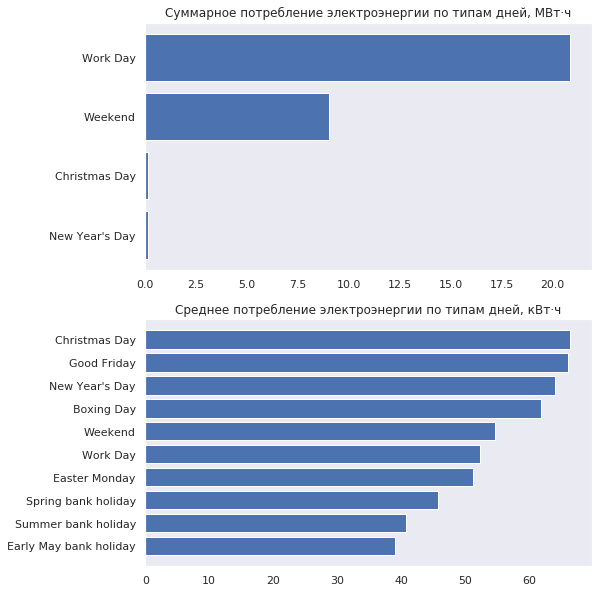

In [0]:
t1 = energy_use_d.groupby('Type')['energy_sum']\
                 .agg({'sum_group': 'sum',
                       'mean_group': 'mean'})\
                 .reset_index()
t2 = t1.sort_values(by='sum_group').tail(4)
t3 = t1.sort_values(by='mean_group')
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
axes[0].grid(b=None)
axes[0].barh(y=t2['Type'], width=t2['sum_group'] / 1_000_000)
axes[0].set_title('Суммарное потребление электроэнергии по типам дней, МВт·ч')
axes[1].grid(b=None)
axes[1].barh(y=t3['Type'], width=t3['mean_group'] / 1_000)
axes[1].set_title('Среднее потребление электроэнергии по типам дней, кВт·ч');

Выводы по данным:

Поскольку рабочих дней суммарно больше, то по ним больше всего данных о потреблении, на втором месте выходные по этой же самой причине.

Среднее потребление максимально в рождественские и новогодние праздники, примерно на 25-30% больше, чем в рабочие дни. Можно сделать вывод, что эти праздники предпочитают отмечать дома.

### Потребление энергии в разбивке по дням недели

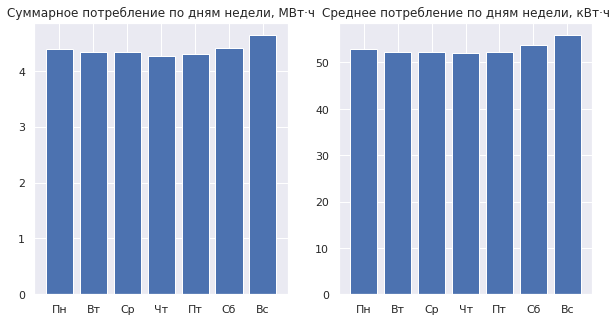

In [0]:
t1 = energy_use_d.groupby('dow')['energy_sum']\
                 .agg({'sum_group': 'sum',
                       'mean_group': 'mean'})\
                 .reset_index()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].bar(x='Пн Вт Ср Чт Пт Сб Вс'.split(),
            height=t1['sum_group'] / 1_000_000)
axes[0].set_title('Суммарное потребление по дням недели, МВт·ч')
axes[1].bar(x='Пн Вт Ср Чт Пт Сб Вс'.split(), 
            height=t1['mean_group'] / 1_000)
axes[1].set_title('Среднее потребление по дням недели, кВт·ч');

Выводы по графикам - суммарные и средние показаниям говорят нам, что потребление энергии растёт в воскресенье

### Влияние времени года на потребление электроэнергии

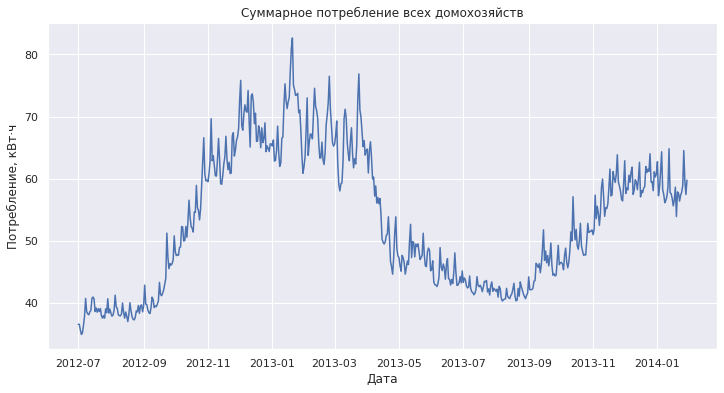

In [0]:
plt.figure(figsize=(12, 6))
plt.title('Суммарное потребление всех домохозяйств')
t1 = energy_use_d.copy()
t1['energy_sum'] /= 1_000
axe = sns.lineplot(x='day', y='energy_sum', data=t1)
axe.set(xlabel='Дата', ylabel='Потребление, кВт·ч');

Из графика видно, что в целом потребление растет в период с октября и достигает пика в январе, затем снижается

### Среднесуточное потребление электроэнергии в течение последнего года для разных групп ACORN, категорий комфорта и способов расчета за электроэнергию

Посмотрим среднесуточное потребление электроэнергии в течении последнего года для разных групп ACORN, категорий комфорта и способов расчета за электроэнергию, выбрав из каждой группы ACORN по пять наибольших потребителей энергии (в датасете не так много категорий комфорта и видов расчетов за электроэнергию, и в большинстве своём эти категории распределены неравномерно в количественном выражении домохозяйств). Анализ будем проводить по среднему потреблению

In [0]:
top5_by_Acorn = {}
# {'ACORN-A': ['MAC...', 'MAC...', 'MAC...', 'MAC...', 'MAC...'],
#  'ACORN-B': ['MAC...', 'MAC...', 'MAC...', 'MAC...', 'MAC...'],
# ... }
for row in energy_use_hh\
            .sort_values(by='energy_sum',
                        ascending=False)\
            .itertuples():
    if row.Acorn not in top5_by_Acorn:
        top5_by_Acorn[row.Acorn] = [row.LCLid]
    else:
        if len(top5_by_Acorn[row.Acorn]) < 5:
            top5_by_Acorn[row.Acorn].append(row.LCLid)
assert all(len(e) == 5 for e in top5_by_Acorn.values())

LCLids = []
for lclids in top5_by_Acorn.values():
    LCLids.extend(lclids)

In [0]:
lclids_energy = get_energy_by_LCLid(LCLids)  
lclids_energy['tstp'] = lclids_energy['tstp'].dt.normalize()
lclids_energy = lclids_energy\
    .groupby(by=['LCLid', 'tstp'])\
    .sum()\
    .reset_index()

retrieving files: 100% (85 of 85) |######| Elapsed Time: 0:00:57 Time:  0:00:57


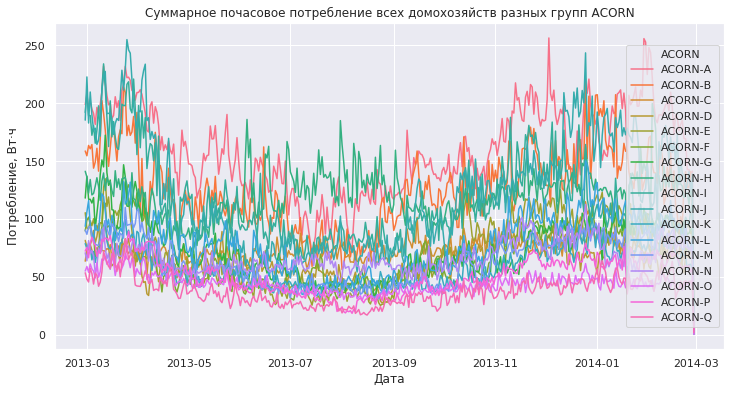

In [0]:
t1 = energy_use_hh[['LCLid', 'Acorn']]\
    .merge(lclids_energy, on ='LCLid')\
    .groupby(by=['Acorn', 'tstp'])['energy']\
    .mean()\
    .reset_index()
start_period = t1.tstp.max() - timedelta(days=365)
t1 = t1[t1['tstp'] >= start_period]
t1.rename(columns={'Acorn': 'ACORN'}, inplace=True)
plt.figure(figsize=(12, 6))
plt.title('Суммарное почасовое потребление всех '
    'домохозяйств разных групп ACORN')
axe = sns.lineplot(x='tstp', y='energy', hue='ACORN', data=t1)
axe.set(xlabel='Дата', ylabel='Потребление, Вт·ч');

Большое количество групп ACORN затрудняет чтение графика, поэтому выберем три группы с максимальным потреблением и посмотрим их данные

In [0]:
lclids_energy_top =  get_energy_by_LCLid(LCLids[:15])   
lclids_energy_top['tstp'] = lclids_energy_top['tstp'].dt.normalize()
lclids_energy_top = lclids_energy_top\
    .groupby(by=['LCLid', 'tstp'])\
    .sum()\
    .reset_index() 

retrieving files: 100% (15 of 15) |######| Elapsed Time: 0:00:09 Time:  0:00:09


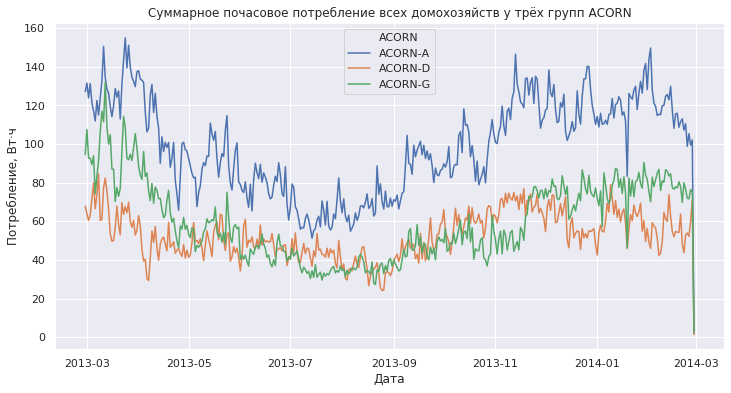

In [0]:
t2 = energy_use_hh[['LCLid','Acorn']]\
    .merge(lclids_energy_top, on ='LCLid')\
    .groupby(by=['Acorn', 'tstp'])['energy']\
    .mean()\
    .reset_index()
start_period2 = t2.tstp.max() - timedelta(days=365)
t2 = t2[t2['tstp'] >= start_period]
t2.rename(columns={'Acorn': 'ACORN'}, inplace=True)
plt.figure(figsize=(12, 6))
plt.title('Суммарное почасовое потребление всех '
    'домохозяйств у трёх групп ACORN')
axe = sns.lineplot(x='tstp', y='energy', hue='ACORN', data=t2)
axe.set(xlabel='Дата', ylabel='Потребление, Вт·ч');

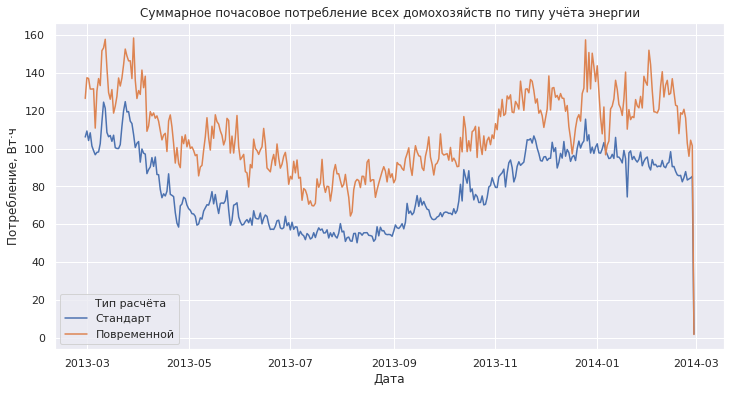

In [0]:
t1 = energy_use_hh[['LCLid', 'stdorToU']]\
    .merge(lclids_energy, on ='LCLid')\
    .groupby(by=['stdorToU', 'tstp'])['energy']\
    .mean()\
    .reset_index()
t1 = t1[t1['tstp'] >= start_period]
t1.rename(columns={'stdorToU': 'Тип расчёта'}, inplace=True)
t1['Тип расчёта'] = t1['Тип расчёта'].apply(
    lambda x: {'Std': 'Стандарт',
               'ToU': 'Повременной'}[x]
)
plt.figure(figsize=(12, 6))
plt.title('Суммарное почасовое потребление всех '
    'домохозяйств по типу учёта энергии')
axe = sns.lineplot(x='tstp', y='energy', hue='Тип расчёта', data=t1)
axe.set(xlabel='Дата', ylabel='Потребление, Вт·ч');

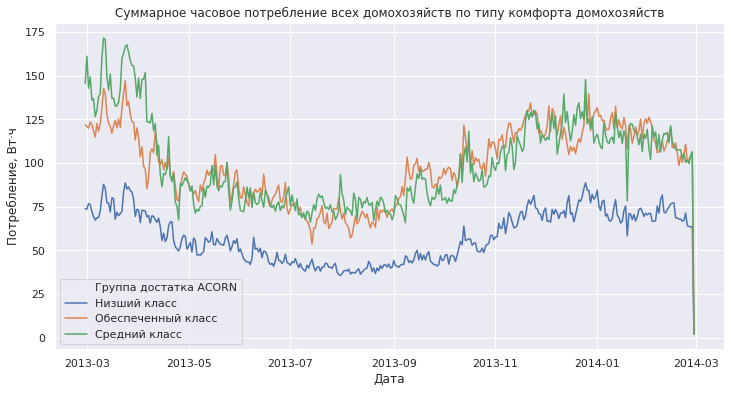

In [0]:
t1 = energy_use_hh[['LCLid', 'Acorn_grouped']]\
    .merge(lclids_energy, on ='LCLid')\
    .groupby(by=['Acorn_grouped', 'tstp'])['energy']\
    .mean()\
    .reset_index()
t1 = t1[t1['tstp'] >= start_period]
t1.rename(columns={'Acorn_grouped': 'Группа достатка ACORN'}, inplace=True)
t1['Группа достатка ACORN'] = t1['Группа достатка ACORN'].apply(
    lambda x: {'Adversity': 'Низший класс',
               'Comfortable': 'Средний класс',
               'Affluent': 'Обеспеченный класс'}[x]
)
plt.figure(figsize=(12, 6))
plt.title('Суммарное часовое потребление всех '
    'домохозяйств по типу комфорта домохозяйств')
axe = sns.lineplot(x='tstp', y='energy', hue='Группа достатка ACORN', data=t1)
axe.set(xlabel='Дата', ylabel='Потребление, Вт·ч');

Из всех трёх графиков видно, что в целом потребление электроэнергии падает в период с июля по сентябрь и имеет рост в период с сентября по январь.

## Анализ потребления в зависимости от погодных условий

Рассмотрим потребление энергии в зависимости от погодных условий: максимальной и минимальной суточной температуры, скорости и направления ветра, а так же видимости и погоды в целом в течение дня

### Потребление электроэнергии в зависимости от максимальной и минимальной суточных температур

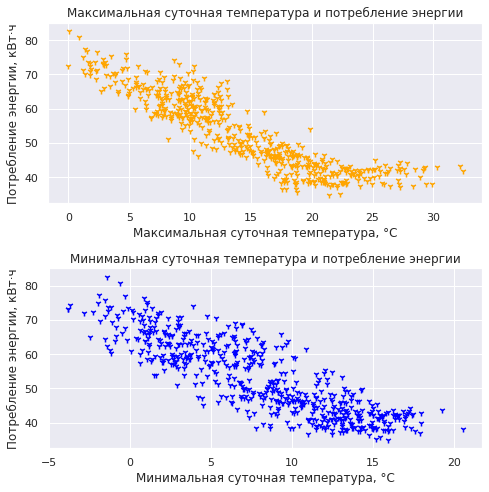

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), tight_layout=True)
axes[0].scatter(
    x=energy_use_d['temperatureMax'],
    y=energy_use_d['energy_sum'] / 1_000,
    marker='1',
    color='orange')
axes[0].set_title('Максимальная суточная температура и потребление энергии')
axes[0].set_xlabel('Максимальная суточная температура, °C')
axes[0].set_ylabel('Потребление энергии, кВт·ч')
axes[1].scatter(
    x=energy_use_d['temperatureMin'],
    y=energy_use_d['energy_sum'] / 1_000,
    marker='1',
    color='blue')
axes[1].set_title('Минимальная суточная температура и потребление энергии')
axes[1].set_xlabel('Минимальная суточная температура, °C')
axes[1].set_ylabel('Потребление энергии, кВт·ч');

### Влияние ветра на потребление энергии

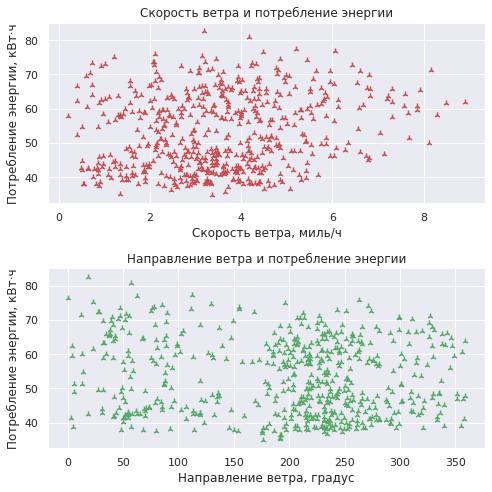

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), tight_layout=True)
axes[0].scatter(
    x=energy_use_d['windSpeed'],
    y=energy_use_d['energy_sum'] / 1_000,
    marker='2',
    color='r')
axes[0].set_title('Скорость ветра и потребление энергии')
axes[0].set_xlabel('Скорость ветра, миль/ч')
axes[0].set_ylabel('Потребление энергии, кВт·ч')
axes[1].scatter(
    x=energy_use_d['windBearing'],
    y=energy_use_d['energy_sum'] / 1_000,
    marker='2',
    color='g')
axes[1].set_title('Направление ветра и потребление энергии')
axes[1].set_xlabel('Направление ветра, градус')
axes[1].set_ylabel('Потребление энергии, кВт·ч');

Выводы по графикам зависимости потребления от температуры, направления и скорости ветра:

* Наиболее характерно высокое потребление энергии при понижении температуры, это видно на графиках максимальной и минимальной суточной температуры. С ростом температуры потребление энергии падает и в диапазоне от 20°С и выше уже не особо зависит от неё.
* График потребления электроэнергии от скорости ветра "размазан" по всей координатной плоскости, но и тут прослеживается некоторая закономерность - при скорости от 2 до 5,5 миль/ч потребление находится в максимальной зоне (для большей части данных), возможно это связано с тем, что указаннные скорости - это наиболее частые показатели для данной местности.
* График потребления электроэнергии от направления ветра так же "размазан" по всей координатной плоскости, но в данном случае более явно видно, что при направлении ветра от 200 до 260 градусов по азимуту потребление максимально - это соответствует юго-западному направлению ветра

### Влияние ясной/дождливой погоды на потребление энергии

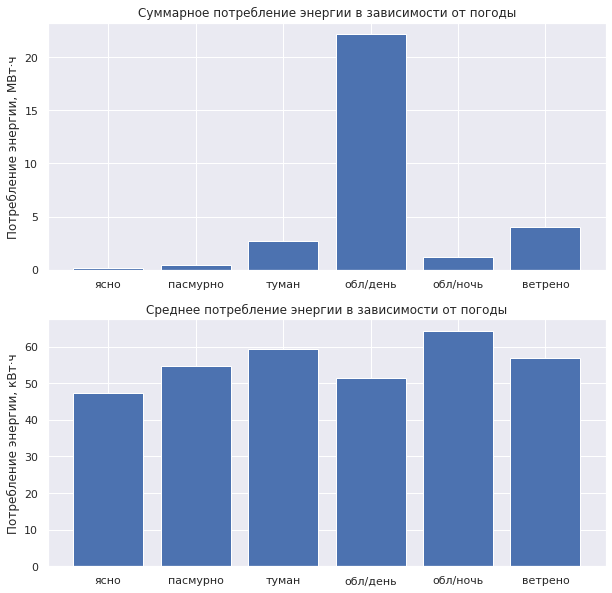

In [0]:
t1 = energy_use_d.groupby('icon')['energy_sum']\
                 .agg({'sum_group': 'sum',
                       'mean_group': 'mean'})\
                 .rename({'clear-day': 'ясно',
                         'cloudy': 'пасмурно',
                         'fog': 'туман',
                         'partly-cloudy-day': 'обл/день',
                         'partly-cloudy-night': 'обл/ночь',
                         'wind': 'ветрено'})\
                 .reset_index()
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].bar(x=t1['icon'], height=t1['sum_group'] / 1_000_000)
axes[0].set_ylabel('Потребление энергии, МВт·ч')
axes[0].set_title('Суммарное потребление энергии в зависимости от погоды')
axes[1].bar(x=t1['icon'], height=t1['mean_group'] / 1_000)
axes[1].set_ylabel('Потребление энергии, кВт·ч')
axes[1].set_title('Среднее потребление энергии в зависимости от погоды');

Выводы по графикам:

Суммарное потребление максимально в пасмурный день, но, вероятно, это связано с тем, что таких дней просто больше.

А вот среднее потребление дает нам понять, что потребление электроэнергии растёт в пасмурную ночь и туман

### Влияние видимости на потребление энергии

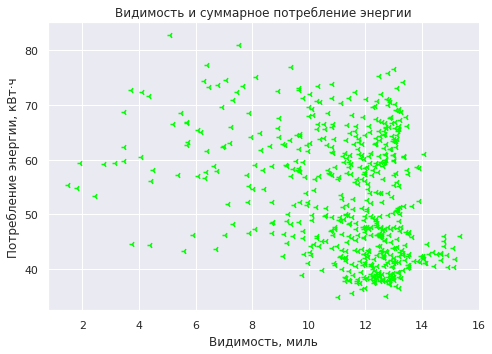

In [0]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=energy_use_d['visibility'],
    y=energy_use_d['energy_sum'] / 1_000,
    marker='3',
    color='lime')
axes.set_title('Видимость и суммарное потребление энергии')
axes.set_xlabel('Видимость, миль')
axes.set_ylabel('Потребление энергии, кВт·ч');

Видно, что особой зависимости потребления энергии от видимости нет, и вероятно видимость 11-13,5 миль - наиболее часто встречающаяся в датасете

### Тип дня, температура и потребление

Ранее мы выявили, что потребление энергии из погодных условий имеет некоторую корреляцию с температурой, и чуть ранее рассмотрели корреляцию потребления в зависимости от того праздник, рабочий или выходной день. Посмотрим, как связаны между собой эти параметры

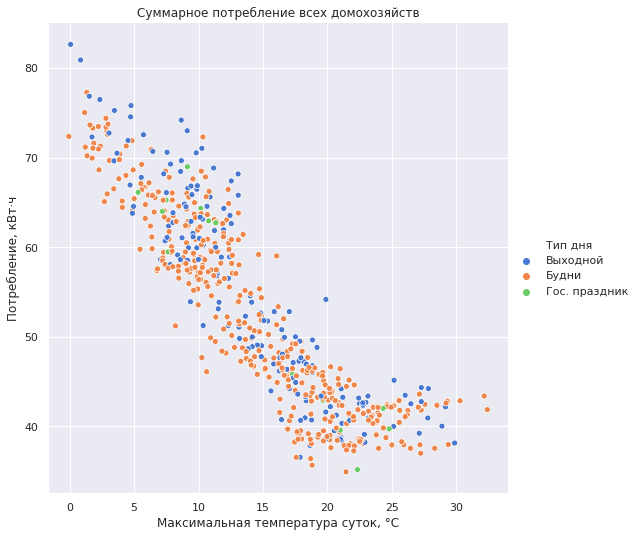

In [0]:
def z(name):
    if name in ('Weekend', 'Work Day'):
        return {
            'Weekend': 'Выходной',
            'Work Day': 'Будни'
            }[name]
    else:
        return 'Гос. праздник'

t1 = energy_use_d.copy()
t1['energy_sum'] /= 1_000
t1['Type'] = t1['Type'].apply(z)
t1.rename(columns={'Type': 'Тип дня'}, inplace=True)
axe = sns.relplot(
    x='temperatureMax',
    y='energy_sum',
    hue='Тип дня',
    palette='muted',
    height=7.4,
    data=t1)
axe.set(xlabel='Максимальная температура суток, °C',
        ylabel='Потребление, кВт·ч')
plt.title('Суммарное потребление всех домохозяйств');


Как мы установили ранее, потребление электроэнергии растёт при падении температуры. Также из графика видно, что при падении температуры потребление электроэнергии в выходные дни растёт гораздо значительнее по сравнению с будними днями. А при температуре выше 15 градусов разрыв сокращается и сводится к минимуму.



## Потребление электроэнергии в зависимости от времени суток

Рассмотрим зависимость потребления от времени суток

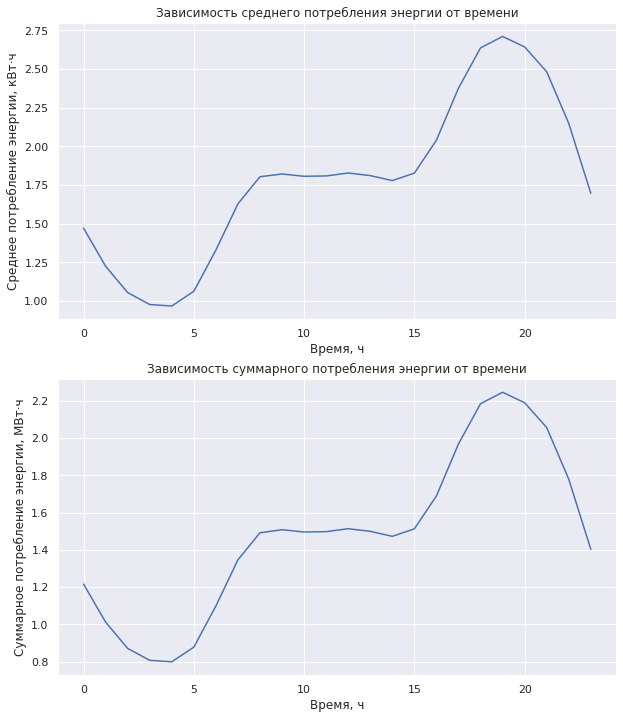

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
t1 = energy_use_h.groupby('hour')['energy']\
                 .agg({'sum_group': 'sum',
                       'mean_group': 'mean'})\
                 .reset_index()
axes[0].plot(t1['hour'], t1['mean_group'] / 1_000) 
axes[0].set_title('Зависимость среднего потребления энергии от времени')
axes[0].set_xlabel('Время, ч')
axes[0].set_ylabel('Среднее потребление энергии, кВт·ч')
axes[1].plot(t1['hour'], t1['sum_group'] / 1_000_000) 
axes[1].set_title('Зависимость суммарного потребления энергии от времени')
axes[1].set_xlabel('Время, ч')
axes[1].set_ylabel('Суммарное потребление энергии, МВт·ч');

Выводы по графикам - видно, что и суммарное и среднее потребление энергии растёт в промежутке с 15 до 20 часов, и падает в промежутке с 20 до 5 часов. Пика потребления достигает в 19 часов, а минимума - в 4 часа.

## Анализ влияния различных факторов для выборочных домохозяйств

Рассмотрим график потребления электроэнергии по часам для пользователя с максимальным энергопотреблением и для пяти пользователей с максимальным потреблением энергии, а так же их максимальные и минимальные значения энергопотребления

Список пользователей с максимальным потреблением энергии:

In [0]:
energy_use_hh.sort_values(
    by='energy_sum', 
    ascending=False).head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file,energy_sum
30,MAC004179,Std,ACORN-A,Affluent,block_0,58472.117002
117,MAC005406,Std,ACORN-A,Affluent,block_2,42989.229013
59,MAC001145,Std,ACORN-A,Affluent,block_1,37690.695995
544,MAC000985,ToU,ACORN-D,Affluent,block_10,37308.725996
72,MAC000557,Std,ACORN-A,Affluent,block_1,36895.496011


retrieving files: 100% (5 of 5) |########| Elapsed Time: 0:00:03 Time:  0:00:03


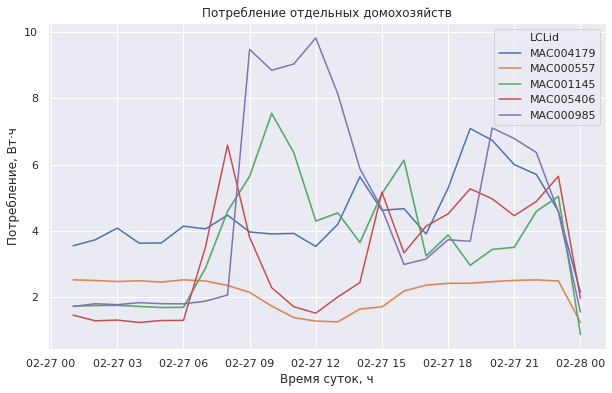

In [0]:
t1 = get_energy_by_LCLid(
    energy_use_hh.sort_values(
        by='energy_sum',
        ascending=False).head()['LCLid']
)
t1 = t1[t1['tstp'] > t1['tstp'].max() - timedelta(days=1)]
plt.figure(figsize=(10, 6))
plt.title('Потребление отдельных домохозяйств');
axe = sns.lineplot(x='tstp', y='energy', hue='LCLid', data=t1)
axe.set(xlabel='Время суток, ч', ylabel='Потребление, Вт·ч');

Из графика почасового потребления видно, что домохозяйство с максимальным энергопотреблением (MAC004179) в течение дня имеет достаточно ровынй и высокий, по сравнению с другими домохозяйствами, график. Бросается в глаза домохозяйство MAC000985, его график потребления не ровный и имеет резкий скачок потребления в период с 9 до 14 часов. Посмотрев тип расчёта понимаем, что это домохозяйство с оплатой, зависящей от времени суток.

Рассмотрим его график потребления в течении нескольких дней

retrieving files: 100% (1 of 1) |########| Elapsed Time: 0:00:00 Time:  0:00:00


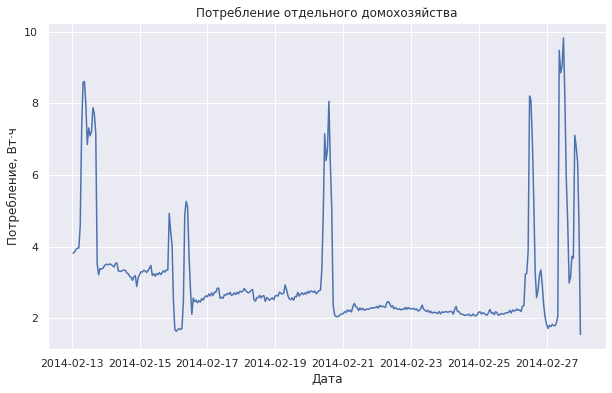

In [0]:
t1 = get_energy_by_LCLid(['MAC000985'])
t1 = t1[t1['tstp'] > t1['tstp'].max() - timedelta(days=15)]
plt.figure(figsize=(10, 6))
plt.title('Потребление отдельного домохозяйства');
axe = sns.lineplot(x='tstp', y='energy', data=t1)
axe.set(xlabel='Дата', ylabel='Потребление, Вт·ч');

retrieving files: 100% (1 of 1) |########| Elapsed Time: 0:00:00 Time:  0:00:00


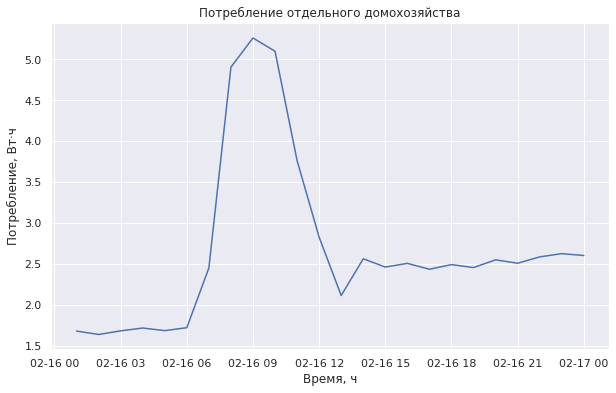

In [0]:
t1 = get_energy_by_LCLid(['MAC000985'])
back_days = 12
t1 = t1[(t1['tstp'] > t1['tstp'].max() - timedelta(days=back_days)) & 
        (t1['tstp'] <= t1['tstp'].max() - timedelta(days=back_days - 1))]
plt.figure(figsize=(10, 6))
plt.title('Потребление отдельного домохозяйства');
axe = sns.lineplot(x='tstp', y='energy', data=t1)
axe.set(xlabel='Время, ч', ylabel='Потребление, Вт·ч');

Видно, что потребление электроэнергии имеет скачкообразный характер. Если рассматривать более детально, то можно заметить, что основное потребление падает на дневное время в промежутке между 6 и 9 часами

Рассмотрим график потребления электроэнергии по часам для пользователя с минимальным энергопотреблением и для десяти пользователей, минимально потребляющих энергию, а так же их максимальные и минимальные значения энергопотребления

In [0]:
energy_use_hh.nsmallest(200, 'energy_sum')

,LCLid,stdorToU,Acorn,Acorn_grouped,file,energy_sum
330,MAC005565,ToU,ACORN-C,Affluent,block_6,0.000
865,MAC001957,Std,ACORN-E,Affluent,block_17,0.000
2512,MAC001300,Std,ACORN-F,Comfortable,block_50,0.000
2623,MAC002110,ToU,ACORN-F,Comfortable,block_52,0.000
3331,MAC001150,Std,ACORN-H,Comfortable,block_66,0.000
...,...,...,...,...,...,...
1729,MAC004893,ToU,ACORN-E,Affluent,block_34,1203.715
5153,MAC003530,Std,ACORN-Q,Adversity,block_103,1213.377
5158,MAC003546,Std,ACORN-Q,Adversity,block_103,1215.919
676,MAC005405,Std,ACORN-E,Affluent,block_13,1220.004


Для анализа возьмем верхние десять домохозяйств из двух сотен самых малопотребляющих. Посмотрим их показания и проверим, что имеем данные за анализируемый день по всем домохозяйствам за все интересующие часы

In [0]:
energy_use_hh.nsmallest(200, 'energy_sum')[-10:]

,LCLid,stdorToU,Acorn,Acorn_grouped,file,energy_sum
4638,MAC004559,ToU,ACORN-P,Adversity,block_92,1191.495
1744,MAC000770,Std,ACORN-E,Affluent,block_34,1192.124
3612,MAC003846,Std,ACORN-J,Comfortable,block_72,1193.280
1871,MAC001287,Std,ACORN-E,Affluent,block_37,1195.764
1054,MAC004536,Std,ACORN-E,Affluent,block_21,1198.841
1729,MAC004893,ToU,ACORN-E,Affluent,block_34,1203.715
5153,MAC003530,Std,ACORN-Q,Adversity,block_103,1213.377
5158,MAC003546,Std,ACORN-Q,Adversity,block_103,1215.919
676,MAC005405,Std,ACORN-E,Affluent,block_13,1220.004
392,MAC000619,Std,ACORN-D,Affluent,block_7,1223.463


retrieving files: 100% (10 of 10) |######| Elapsed Time: 0:00:06 Time:  0:00:06


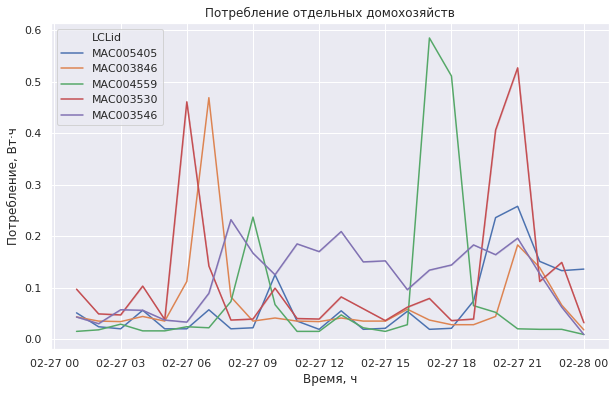

In [0]:
t1 = get_energy_by_LCLid(
    energy_use_hh.nsmallest(200, 'energy_sum')[-10:]['LCLid'])
t1 = t1[t1['tstp'] > t1['tstp'].max() - timedelta(days=1)]
plt.figure(figsize=(10, 6))
plt.title('Потребление отдельных домохозяйств');
axe = sns.lineplot(x='tstp', y='energy', hue='LCLid', data=t1)
axe.set(xlabel='Время, ч', ylabel='Потребление, Вт·ч');

Видим, что потребление шести из десяти анализируемых домохозяйств за интересующую дату есть, но оно ничтожно мало, и малейшее изменение потребления ведёт резким скачкам

Посмотрим, как будет распределяться потребление электроэнергии в зависимости от сочетания группы факторов, посмотрим суммарное и среднее потребление энергии

In [0]:
energy_use_hh.groupby(['stdorToU',
                       'Acorn',
                       'Acorn_grouped'])['energy_sum']\
             .sum()\
             .reset_index()\
             .nlargest(10, 'energy_sum')

,stdorToU,Acorn,Acorn_grouped,energy_sum
4,Std,ACORN-E,Affluent,7.130737e+06
16,Std,ACORN-Q,Adversity,2.971788e+06
5,Std,ACORN-F,Comfortable,2.797051e+06
7,Std,ACORN-H,Comfortable,2.219668e+06
21,ToU,ACORN-E,Affluent,1.777664e+06
3,Std,ACORN-D,Affluent,1.663604e+06
11,Std,ACORN-L,Adversity,1.439558e+06
0,Std,ACORN-A,Affluent,1.238569e+06
6,Std,ACORN-G,Comfortable,8.791683e+05
10,Std,ACORN-K,Adversity,7.928148e+05


In [0]:
energy_use_hh.groupby(['stdorToU',
                       'Acorn',
                       'Acorn_grouped'])['energy_sum']\
             .mean()\
             .reset_index()\
             .nlargest(10, 'energy_sum')

,stdorToU,Acorn,Acorn_grouped,energy_sum
0,Std,ACORN-A,Affluent,10496.345949
17,ToU,ACORN-A,Affluent,8467.441461
18,ToU,ACORN-B,Affluent,8340.018999
3,Std,ACORN-D,Affluent,7596.364329
20,ToU,ACORN-D,Affluent,7281.304274
2,Std,ACORN-C,Affluent,6554.673707
9,Std,ACORN-J,Comfortable,6162.819728
7,Std,ACORN-H,Comfortable,5982.932348
1,Std,ACORN-B,Affluent,5854.118381
4,Std,ACORN-E,Affluent,5806.789340


Из данных видно, что суммарное потребление выше у потребителей относящихся к ACORN группе ACORN-E. Как мы видели ранее, их просто больше в количественном выражении, а вот среднее потребление подтверждает сделанные ранее выводы: группа ACORN-A имеет самые большие значения, при этом как в стандартной схемы оплаты, так и по времени

Посмотрим среднесуточное потребление электроэнергии в зависимости от температуры с разбивкой на категорию Acorn, категорию комфорта и метод расчёта электроэнергии

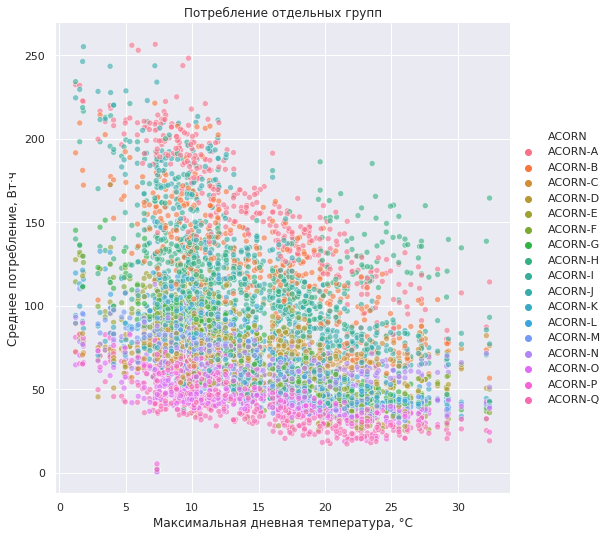

In [0]:
t1 = informations_households[['LCLid', 'Acorn']]\
    .merge(lclids_energy, on='LCLid')\
    .groupby(by=['Acorn', 'tstp'])['energy']\
    .mean()\
    .reset_index()\
    .merge(
        weather_daily_darksky[['day', 'temperatureMax']], 
        left_on='tstp', 
        right_on='day')                                               
start_period = t1.tstp.max() - timedelta(days=365)
t1 = t1[t1['tstp'] >= start_period]
t1.rename(columns={'Acorn': 'ACORN'}, inplace=True)
axe = sns.relplot(x="temperatureMax",
            y="energy", 
            hue="ACORN", 
            alpha=.6, 
            height=7.4, 
            data=t1)
plt.title('Потребление отдельных групп');
axe.set(xlabel='Максимальная дневная температура, °C',
        ylabel='Среднее потребление, Вт·ч');

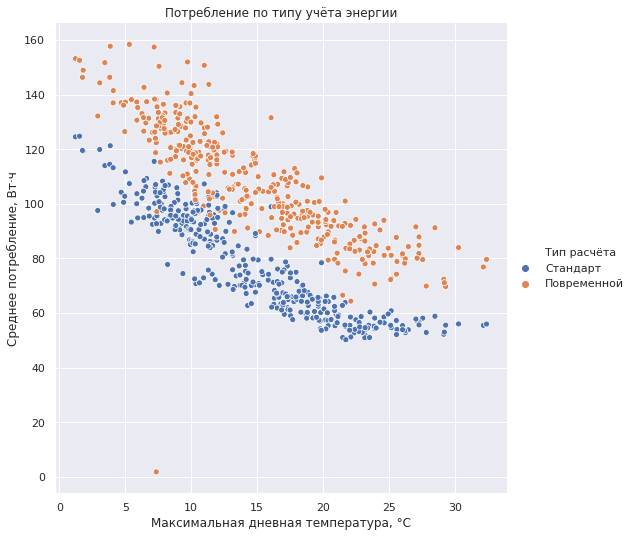

In [0]:
t1 = informations_households[['LCLid', 'stdorToU']]\
    .merge(lclids_energy, on='LCLid')\
    .groupby(by=['stdorToU', 'tstp'])['energy']\
    .mean()\
    .reset_index()\
    .merge(weather_daily_darksky[['day', 'temperatureMax']], 
            left_on='tstp', 
            right_on='day')                                               
start_period = t1.tstp.max() - timedelta(days=365)
t1 = t1[t1['tstp'] >= start_period]
t1.rename(columns={'stdorToU': 'Тип расчёта'}, inplace=True)
t1['Тип расчёта'] = t1['Тип расчёта'].apply(
    lambda x: {'Std': 'Стандарт',
               'ToU': 'Повременной'}[x]
)
axe = sns.relplot(x='temperatureMax',
            y='energy',
            hue='Тип расчёта',
            height=7.4,
            data=t1)
plt.title('Потребление по типу учёта энергии');
axe.set(xlabel='Максимальная дневная температура, °C',
        ylabel='Среднее потребление, Вт·ч');

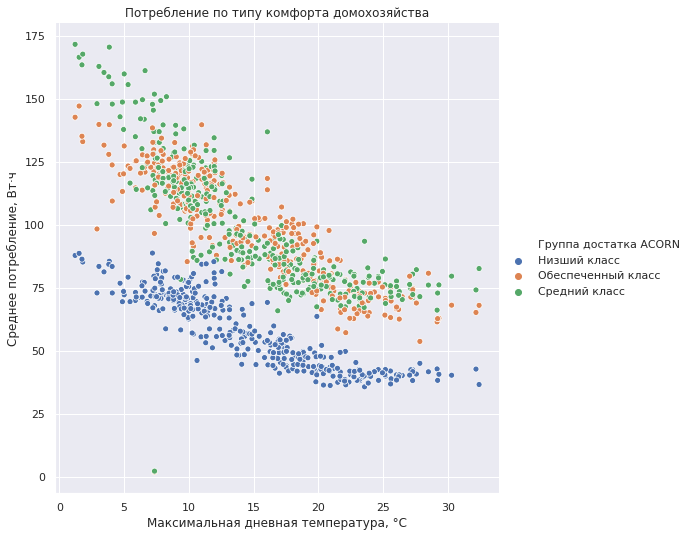

In [0]:
t1 = informations_households[['LCLid', 'Acorn_grouped']]\
    .merge(lclids_energy, on='LCLid')\
    .groupby(by=['Acorn_grouped', 'tstp'])['energy']\
    .mean()\
    .reset_index()\
    .merge(weather_daily_darksky[['day', 'temperatureMax']], 
            left_on='tstp', 
            right_on='day')                                               
start_period = t1.tstp.max()- timedelta(days=365)
t1 = t1[t1['tstp'] >= start_period]
t1.rename(columns={'Acorn_grouped': 'Группа достатка ACORN'}, inplace=True)
t1['Группа достатка ACORN'] = t1['Группа достатка ACORN'].apply(
    lambda x: {'Adversity': 'Низший класс',
               'Comfortable': 'Средний класс',
               'Affluent': 'Обеспеченный класс'}[x]
)
axe = sns.relplot(x="temperatureMax",
            y="energy",
            hue="Группа достатка ACORN",
            height=7.4,
            data=t1)
plt.title('Потребление по типу комфорта домохозяйства');
axe.set(xlabel='Максимальная дневная температура, °C',
        ylabel='Среднее потребление, Вт·ч');

Выводы по графикам.

В целом разбивка на категории ACORN, типу расчёта (по учёту времени или без) и категории комфорта повторяют полученые ранее данные о том, что при падении температуры наблюдается рост потребления электроэнергии, а при её росте - снижение потребления. Интересно, что в целом (а особенно это заметно при низких температурах) среднее потребление электроэнергии Обеспеченного класса ниже, чем среднее потребление среднего класса.

# Выводы по датасету

По итогам анализа представленного набора данных можно выявить следующие наиболее значимые факторы и их значения, влияющие на энергопотребление:
* Категория ACORN – выявлено влияние категории Acorn на среднее потребление, установлено что максимальное среднее потребление электроэнергии у категории ACORN-A, которую можно описать как пожилой человек 65-74 лет, имеющий большой дорогой дом, живущий с детьми
* Категория комфорта – максимальное среднее потребление у группы среднего достатка, а не комфортного как можно было бы предположить изначально
* Правила расчёта электроэнергии от времени – средние показатели потребления не дают информацию о росте потребления электроэнергии при том или ином виде расчёта, но для домохозяйств с повременным расчетом характерен рост потребления электроэнергии в период с 9 до 15 часов (вероятно, это льготный период), в то время как домохозяйства со стандартным расчётом имеют более ровный график потребления электроэнергии в течении всего дня
* Категории дней – анализ потребления электроэнергии показал рост в рождественские праздники и на Новый год
* Времена года и месяцы – анализ показал, что потребление электроэнергии растёт в период с октября по январь и падает с июля по август, т.е. зафиксирован рост в осенне-зимний период и снижение в летний
* Температура воздуха – анализ потребления электроэнергии в зависимости от температуры показал рост потребления электроэнергии при температуре 10 градусов и ниже, и снижение энергопотребления при ее повышении температуры, при температуре от 15 градусов потребление электроэнергии уже не имеет явной зависимости от температуры
* Скорость, направление ветра, видимость – анализ данных показателей и их влияние на потребление электроэнергии не дал информации о корреляции, но распределение показателей величин на графике дают понять о том, какие значения наиболее часты для представленного набора данных
* Время суток – почасовой анализ показал, что потребление электроэнергии растет в промежутке между 15 и 20 часами, и падает с 20 до 5 утра

Комбинированный анализ параметров в целом подтверждает обнаруженные ранее закономерности:
* Температура и тип дня недели – анализ показал, что в выходные и праздничные дни рост потребления электроэнергии при снижении температуры прослеживается более явно, нежели для будних дней.
* Сочетание группы ACORN, вида расчета от времени суток и категории комфорта – подтверждает выявленные ранее закономерности: максимальное среднее потребление у сочетания ACORN-A, средний уровень дохода и стандартный расчет электроэнергии.
* Температура и категория ACORN/вид расчета/категория комфорта – данные анализа так же подтверждают выявленные ранее закономерности: рост потребления электроэнергии очень сильно зависит от группы ACORN и температуры. Также обнаружена интересная особенность, что при снижении температуры ниже 5-6 градусов влияние категории комфорта изменяется: выше указанной температуры домохозяйства среднего и обеспеченного класса имеют приблизительно равные показатели, где-то даже обеспеченный класс имеет более высокие значения, но при снижении температуры ниже указанной идет резкий рост потребления в среднем классе